In [38]:
#from google.colab import drive
#drive.mount('/content/drive')

In [19]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from pylab import *
import json
import cv2
import h5py
import imageio
from IPython.display import Image

import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    MaxPooling2D,
    UpSampling2D,
    concatenate
)
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#from tensorflow.compat.v1.logging import INFO, set_verbosity

#set_verbosity(INFO)

K.set_image_data_format("channels_first")

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Num GPUs Available:  1
Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pwd

'/Volumes/MX500_1TB/GitHub/Projects/TEM_seg'

In [3]:
# set home directory and data directory
HOME_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/"
IMG_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/img/"
MSK_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/msk/"

#Data Augmentation Path
AUG_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/aug/"

SUB_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/sub_img/"
TRAIN_DATA_DIR = ""
VALID_DATA_DIR = ""
TEST_DATA_DIR = ""

# Encoder(DownSampling) Block

In [13]:
def conv_block(inputs = None, n_filters = 32, dropout_prob = 0, max_pooling = True):


  """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
  """

  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation = 'relu',
                padding = 'same',
                kernel_initializer = 'he_normal')(inputs)

  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation = 'relu',
                padding = 'same',
                kernel_initializer = 'he_normal')(conv)

  # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
  if dropout_prob > 0:
    conv = Dropout(dropout_prob)(conv)

  # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
  if max_pooling:
    next_layer = MaxPooling2D(2, strides = 2)(conv)

  else:
    next_layer = conv

  skip_connection = conv

  return next_layer, skip_connection


# Decoder(UpSampling) Block

In [14]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
  """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
  """

    ### START CODE HERE
  up = Conv2DTranspose(filters = n_filters,
                       kernel_size = 3,
                       strides=2,
                       padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
  #merge = concatenate([up, contractive_input], axis=3)
  merge = concatenate([up, contractive_input], axis=1)
  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(merge)
  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)

  return conv

# UNET Model

In [16]:

def unet_model(input_size=(256, 256, 1), n_filters=32, n_classes=1):
    """ 
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    #conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    conv10 = Conv2D(filters = 1, kernel_size = 1, data_format = 'channels_first',activation='sigmoid')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [20]:
unet= unet_model(input_size=(1,256, 256), n_filters=32, n_classes=1)

In [21]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 256, 256  320         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 256, 256  9248        ['conv2d_12[0][0]']              
                                )                                                             

In [22]:
unet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['BinaryIoU'])

# Load the trained Model/Weights

In [23]:
filename = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/model_50epoch_data700.h5"

In [24]:
from tensorflow.keras.models import load_model
#Weights_DIR = HOME_DIR + ""
#UNET_MODEL =unet.load_weights(Weights_DIR + filename)
UNET_MODEL =unet.load_weights(filename)

# Load the predict file

In [26]:
predict_filename = "E1-60000X-72.tif"
folder_path = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/tif_image/"
image = np.array(imageio.imread(folder_path + predict_filename))

/var/folders/0p/s_v762_d0zbdf1spxr00w4gc0000gn/T/ipykernel_22649/3319587129.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(folder_path + predict_filename)


In [28]:
img_scale=scaler.fit_transform(image.reshape(-1, 1)).reshape(image.shape)

In [33]:
img_scale.shape

(1024, 1024)

In [36]:
predictions = np.zeros((1,1024,1024))
print(predictions.shape)

(1, 1024, 1024)


In [45]:
orig_x = 1024
orig_y = 1024

step_x = 256
step_y = 256

output_x = 256
output_y = 256

seq=[]
predictions = np.zeros((1,1024,1024))

for x in range(0, orig_x-output_x+1, step_x):
    for y in range(0, orig_y-output_y+1, step_y):

            start_x = x
            start_y = y

            X = np.copy(img_scale[start_x: start_x + output_x,
                                  start_y: start_y + output_y])
            X = np.expand_dims(X, axis=0)
            X = np.expand_dims(X, axis=0)
            patch_prediction = unet.predict(X)
            predictions[0, start_x: start_x + output_x, start_y: start_y + output_y] = patch_prediction[0,0,:,:]





1/1 [==============================] - 0s 66ms/step


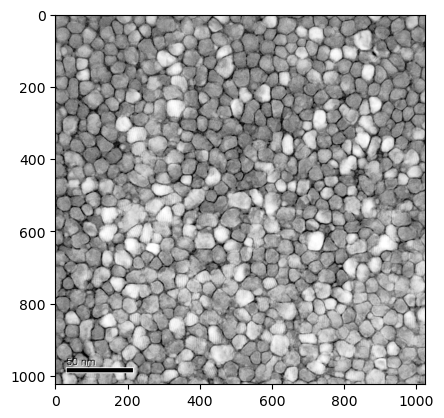

In [55]:
plt.imshow(img_scale,  cmap = 'Greys')

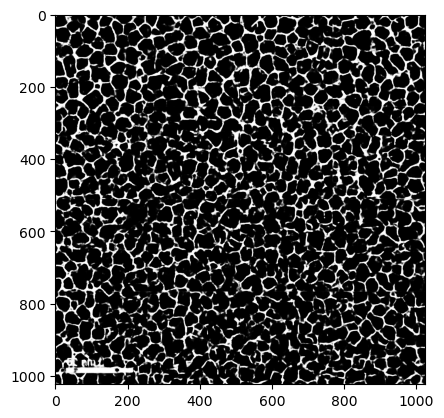

In [48]:
plt.imshow(predictions[0,:,:],  cmap = 'Greys')

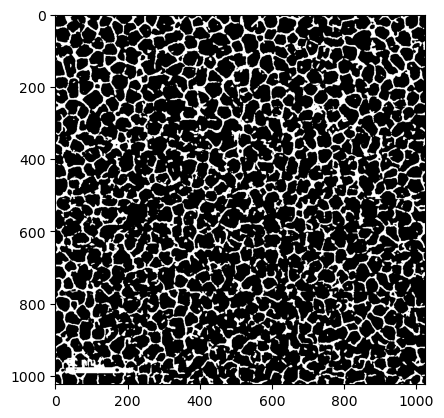

In [53]:
pred_msk = predictions[0,:,:]
thres=0.8
msk = np.zeros(pred_msk.shape)
msk[pred_msk >= thres] = 1
msk[pred_msk < thres] = 0

plt.imshow(msk, cmap = 'Greys')

In [ ]:
def preprocess_image(image_path, input_size=(256, 256)):
    img = Image.open(image_path)
    img = img.resize(input_size)
    img_array = np.array(img) / 255.0  # Normalize pixel values to be in the range [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def slice_and_predict(image_array, model, patch_size=(256, 256)):
    height, width = image_array.shape[1:3]
    stride = patch_size[0] // 2  # You can adjust the stride based on your needs
    predictions = np.zeros_like(image_array)

    for y in range(0, height, stride):
        for x in range(0, width, stride):
            patch = image_array[:, y:y+patch_size[0], x:x+patch_size[1], :]
            patch_prediction = model.predict(patch)
            predictions[:, y:y+patch_size[0], x:x+patch_size[1], :] = patch_prediction

    return predictions

def reconstruct_image(predictions, original_size=(1024, 1024)):
    reconstructed_image = np.zeros((1, *original_size, 1))

    for y in range(0, original_size[0], predictions.shape[1]):
        for x in range(0, original_size[1], predictions.shape[2]):
            reconstructed_image[:, y:y+predictions.shape[1], x:x+predictions.shape[2], :] = predictions

    return reconstructed_image

```python
orig_x = 1024
orig_y = 1024

step_x = 128
step_y = 128

output_x = 256
output_y = 256
num_classes = 2

for i in range(0, len(IMG_list)):
    filename = IMG_list[i]
    img=np.array(imageio.imread(IMG_DIR + IMG_list[i]))
    
    msk=np.array(imageio.imread(MSK_DIR + MSK_list[i]))
    img_scale=scaler.fit_transform(img.reshape(-1, 1)).reshape(img.shape)

    # Initialize features and labels with `None`
    X = None
    Y = None

    for x in range(0, orig_x-output_x+1, step_x):
        for y in range(0, orig_y-output_y+1, step_y):

                start_x = x
                start_y = y

                Y = np.copy(msk[start_x: start_x + output_x,
                                start_y: start_y + output_y])
                #Y = keras.utils.to_categorical(Y, num_classes=num_classes)

                X = np.copy(img_scale[start_x: start_x + output_x,
                                start_y: start_y + output_y])

                    # change dimension of X
                    # from (x_dim, y_dim, z_dim, num_channels)
                    # to (num_channels, x_dim, y_dim, z_dim)
                X = np.expand_dims(X, axis=0)
                Y = np.expand_dims(Y, axis=0)

                    # change dimension of y
                    # from (x_dim, y_dim, z_dim, num_classes)
                    # to (num_classes, x_dim, y_dim, z_dim)
                #Y = np.moveaxis(Y, 3, 0)

                    #excludes the background class
                #Y = Y[:, :, :]

                file=filename \
                +"_x_"+str(start_x) \
                +"_y_"+str(start_y) \
                +"_"

                destination = os.path.join("/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/sub_img/", f"{file}.h5")

                if os.path.exists(destination):
                    # File already exists, do something
                    pass

                else:
                    os.makedirs(os.path.dirname(destination), exist_ok= True)
                    with h5py.File(destination, "w") as f1:
                        dset1 = f1.create_dataset("x", (output_x, output_y), dtype='float32', data=X)
                        dset2 = f1.create_dataset("y", (output_x, output_y), dtype='uint8', data=Y)
                        f1.close()
print("Done")
```

In [88]:
num_channels = 1
num_classes = 1
dim = (256, 256)
X_train = np.zeros((len(config["train"]), num_channels, *dim),
             dtype=np.float64) #float64
y_train = np.zeros((len(config["train"]), num_classes, *dim),
             dtype=np.float64) #float64
# Generate data

#base_dir = "./BraTS-Data/processed/"
directory_train = base_dir + "sub_img/"
print(directory_train)

for i,ID in enumerate(config["train"]):
    # Store sample
    with h5py.File(directory_train + ID, 'r') as f:
        X_train[i] = np.array(f.get("x"))
        y_train[i] = np.array(f.get("y"))

print(X_train.shape)
print(y_train.shape)

/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/sub_img/
(98, 1, 256, 256)
(98, 1, 256, 256)


# Function to define axis corrdianation in image reconstruction

In [30]:
def axis_subimage(axis, origin, step, output):
    if axis == 0:
        start_coord = axis
        end_coord = output - step/2
    elif axis == (origin - output):
        start_coord = step/2
        end_coord = output
    else:
        start_coord = step/2
        end_coord = output - step/2

    return int(start_coord), int(end_coord)

In [31]:
def axis_coord(axis, orig, step, output):
    if axis == 0:
        start_coord = axis
        end_coord = axis + output - step/2 
    elif axis == (orig - output):
        start_coord = axis + step/2
        end_coord = axis + output 
    else:
        start_coord = axis + step/2
        end_coord = axis + output -step/2 

    return int(start_coord), int(end_coord)

# Test coordination code section, don't need to run when reconstruction

In [ ]:
orig_label = np.zeros((125, 80, 80, 64))
i=0
for file in seq:
    filepath = Test_DIR + file
    with h5py.File(filepath, 'r') as f:
        img = np.array(f.get("x"))
        msk = np.array(f.get("y"))
    
    # create the background volume with all 0s
    background = np.zeros((1, 80, 80, 64))
    
    
    mask = np.concatenate((background, msk), axis=0)
    label_3D = np.argmax(mask, axis = 0)

    orig_label[i, :, :, :] = label_3D
    
    i += 1

print("Done")

In [32]:
orig_x = 512
orig_y = 512

step_x = 40
step_y = 40

output_x = 80
output_y = 80

print(seq)

i = np.random.randint(0, 124)
i=124
ax_x = int(seq[i].split("_")[3])
ax_y = int(seq[i].split("_")[5])
ax_z = int(seq[i].split("_")[7])

start_x, end_x = axis_coord(ax_x, orig_x, step_x, output_x)
start_y, end_y = axis_coord(ax_y, orig_y, step_y, output_y)

V_start_x, V_end_x = axis_subimage(ax_x, orig_x, step_x, output_x)
V_start_y, V_end_y = axis_subimage(ax_y, orig_y, step_y, output_y)

print(ax_x)
print(ax_y)

print(seq[i])
print(f"start_x is: {start_x}, end_x is : {end_x}" )
print(f"start_y is: {start_y}, end_y is : {end_y}" )

print(f"image start_x is: {V_start_x}, image end_x is : {V_end_x}, length is : {(V_end_x-V_start_x+1)}" )
print(f"image start_y is: {V_start_y}, image end_y is : {V_end_y}, length is : {(V_end_y-V_start_y+1)}" )


NameError: name 'seq' is not defined